# TRAINING FACE MASK DATASET

### WITH MASK

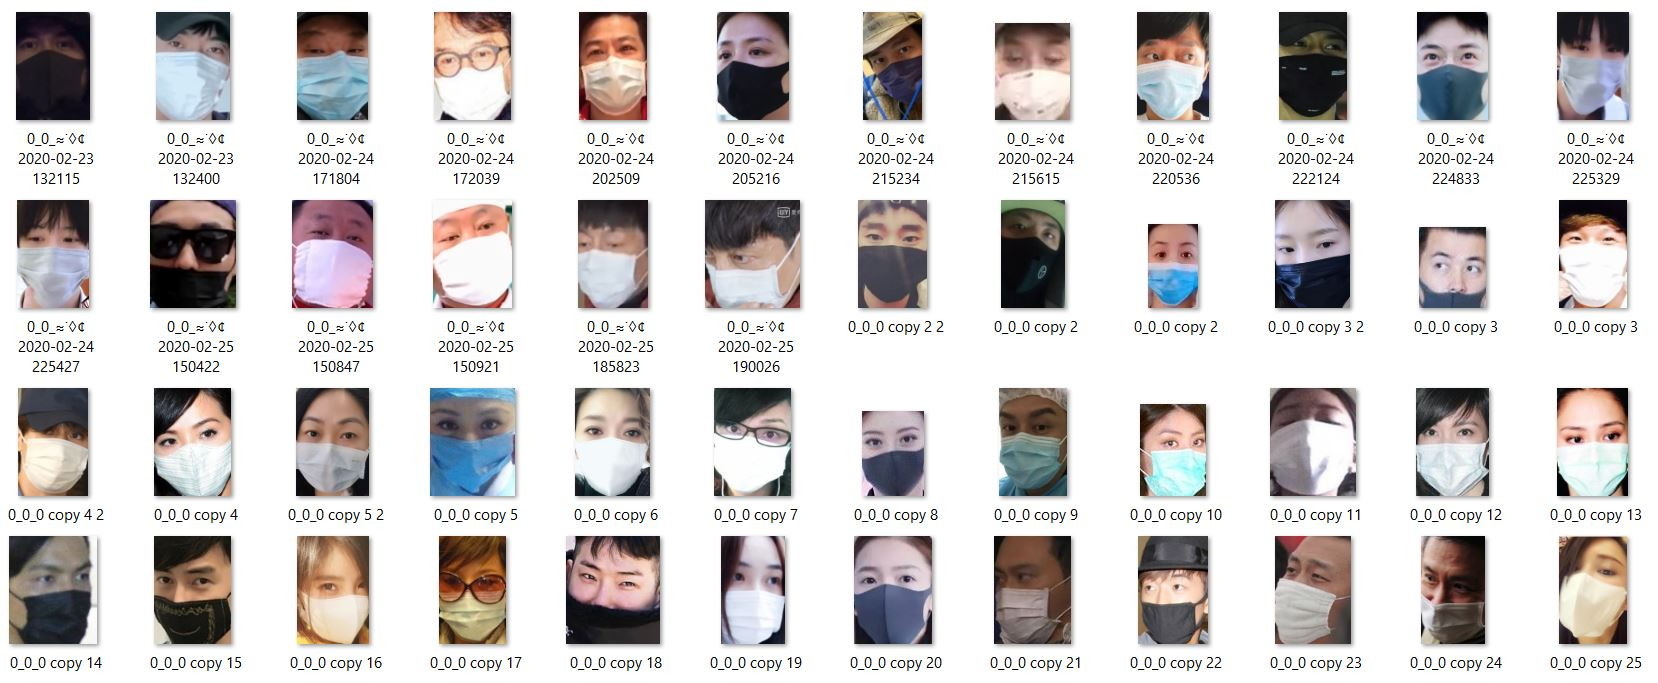

### WITHOUT MASK

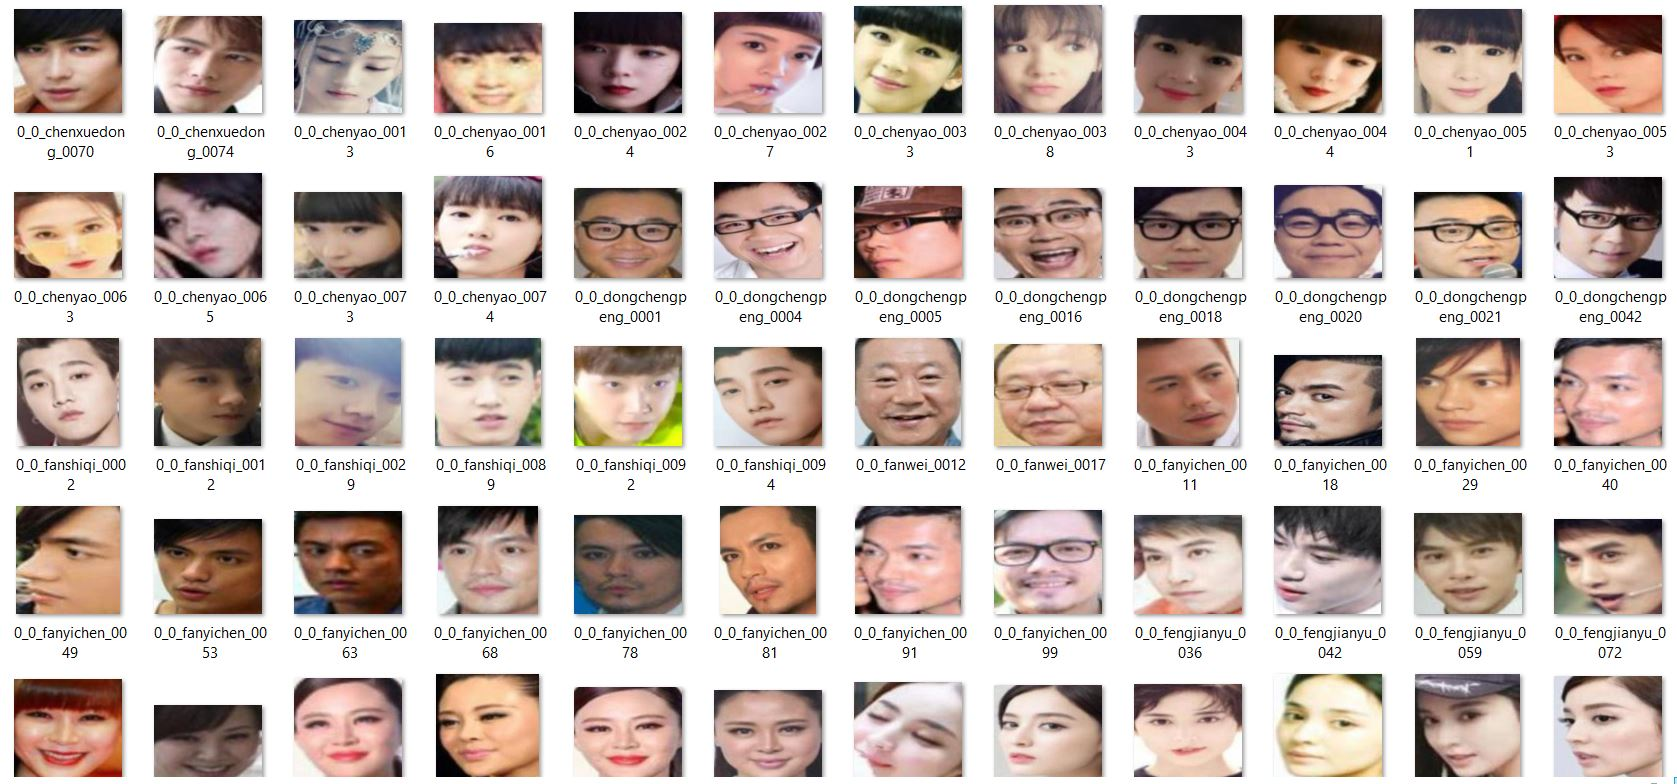

## IMPORTING NECESSARY LIBRARIES

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os


In [22]:
INIT_LR = 1e-4
EPOCHS = 20
BS = 32
directory="dataset"
categories=["with_mask","without_mask"]


In [23]:
print("[INFO] loading images...")

data = []
labels = []
for imagePath in categories:
    path=os.path.join(directory,imagePath)
    for img in os.listdir(path):
        img_path=os.path.join(path,img)
        image = load_img(img_path, target_size=(224, 224))
        image = img_to_array(image)
        image = preprocess_input(image)
        data.append(image)
        labels.append(imagePath)



[INFO] loading images...


C:\Users\SHAKINA\Anaconda3\lib\site-packages\PIL\Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


### PERFORMING ONE HOT ENCODING

In [24]:

lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

data = np.array(data, dtype="float32")
labels = np.array(labels)




### PARTIONING THE DATA INTO TRAINING AND TESTING SPLITS

In [25]:
(trainX, testX, trainY, testY) = train_test_split(data, labels,test_size=0.20, stratify=labels, random_state=42)


aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")



In [26]:
baseModel = MobileNetV2(weights="imagenet", include_top=False,
                        input_tensor=Input(shape=(224, 224, 3)))

headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)



9412608/9406464 [==============================] - 1s 0us/step


In [27]:
model = Model(inputs=baseModel.input, outputs=headModel)

for layer in baseModel.layers:
    layer.trainable = False

print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])


[INFO] compiling model...


In [28]:
print("[INFO] training head...")
H = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS)

# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)



[INFO] training head...
Epoch 1/20
96/96 [==============================] - 137s 1s/step - loss: 0.3414 - accuracy: 0.8532 - val_loss: 0.1067 - val_accuracy: 0.9805
Epoch 2/20
96/96 [==============================] - 133s 1s/step - loss: 0.1270 - accuracy: 0.9570 - val_loss: 0.0721 - val_accuracy: 0.9818
Epoch 3/20
96/96 [==============================] - 136s 1s/step - loss: 0.0829 - accuracy: 0.9750 - val_loss: 0.0554 - val_accuracy: 0.9896
Epoch 4/20
96/96 [==============================] - 138s 1s/step - loss: 0.0721 - accuracy: 0.9750 - val_loss: 0.0502 - val_accuracy: 0.9870
Epoch 5/20
96/96 [==============================] - 138s 1s/step - loss: 0.0669 - accuracy: 0.9786 - val_loss: 0.0440 - val_accuracy: 0.9909
Epoch 6/20
96/96 [==============================] - 139s 1s/step - loss: 0.0613 - accuracy: 0.9793 - val_loss: 0.0409 - val_accuracy: 0.9909
Epoch 7/20
96/96 [==============================] - 138s 1s/step - loss: 0.0427 - accuracy: 0.9842 - val_loss: 0.0406 - val_accura

### CLASSIFICATION REPORT

In [29]:
predIdxs = np.argmax(predIdxs, axis=1)
print(classification_report(testY.argmax(axis=1), predIdxs,target_names=lb.classes_))


              precision    recall  f1-score   support

   with_mask       0.99      0.99      0.99       384
without_mask       0.99      0.99      0.99       386

    accuracy                           0.99       770
   macro avg       0.99      0.99      0.99       770
weighted avg       0.99      0.99      0.99       770

